In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

1 Data

1.1 Create Time Series Data

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

1.2 Split Data


In [3]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

1.3 Windowed Dataset


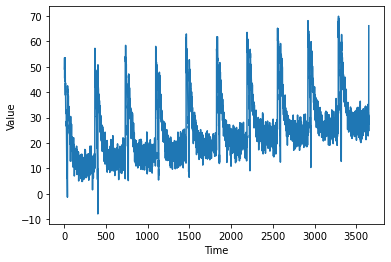

In [4]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
     

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

2 Model

2.1 Train model and Pick learning rate

In [6]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9), metrics=["mae"])

history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


94/94 [==============================] - 16s 35ms/step - loss: 8.5331 - mae: 9.0204 - lr: 1.0000e-08
Epoch 2/100
94/94 [==============================] - 3s 31ms/step - loss: 8.0548 - mae: 8.5392 - lr: 1.1220e-08
Epoch 3/100
94/94 [==============================] - 3s 34ms/step - loss: 7.7249 - mae: 8.2080 - lr: 1.2589e-08
Epoch 4/100
94/94 [==============================] - 3s 31ms/step - loss: 7.5026 - mae: 7.9862 - lr: 1.4125e-08
Epoch 5/100
94/94 [==============================] - 3s 31ms/step - loss: 7.3488 - mae: 7.8287 - lr: 1.5849e-08
Epoch 6/100
94/94 [==============================] - 3s 32ms/step - loss: 7.2340 - mae: 7.7112 - lr: 1.7783e-08
Epoch 7/100
94/94 [==============================] - 3s 34ms/step - loss: 7.1368 - mae: 7.6127 - lr: 1.9953e-08
Epoch 8/100
94/94 [==============================] - 3s 33ms/step - loss: 7.0504 - mae: 7.5257 - lr: 2.2387e-08
Epoch 9/100
94/94 [==============================] - 3s 31ms/step - loss: 6.9634 - mae: 7.4375 - lr: 2.5119e-08
Epo

(1e-08, 0.0001, 0.0, 30.0)

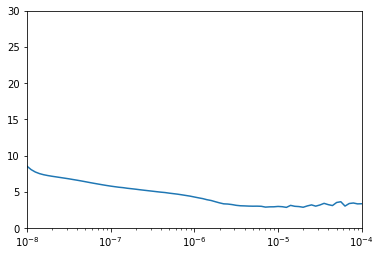

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

2 Model


In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=100,verbose=1)

Epoch 1/100
94/94 [==============================] - 12s 30ms/step - loss: 263.1988 - mae: 10.1378
Epoch 2/100
94/94 [==============================] - 3s 29ms/step - loss: 33.6153 - mae: 3.9017
Epoch 3/100
94/94 [==============================] - 3s 30ms/step - loss: 27.7103 - mae: 3.5518
Epoch 4/100
94/94 [==============================] - 3s 30ms/step - loss: 31.9159 - mae: 3.9759
Epoch 5/100
94/94 [==============================] - 3s 30ms/step - loss: 27.1127 - mae: 3.5515
Epoch 6/100
94/94 [==============================] - 3s 30ms/step - loss: 25.7764 - mae: 3.4461
Epoch 7/100
94/94 [==============================] - 3s 29ms/step - loss: 32.1397 - mae: 3.9959
Epoch 8/100
94/94 [==============================] - 3s 29ms/step - loss: 27.8369 - mae: 3.6121
Epoch 9/100
94/94 [==============================] - 3s 29ms/step - loss: 29.2938 - mae: 3.8187
Epoch 10/100
94/94 [==============================] - 3s 29ms/step - loss: 28.0733 - mae: 3.6757
Epoch 11/100
94/94 [================

3 Forecast


In [ ]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

4 Metric: MAE


In [11]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()


3.1271286

5 Plot MAE and Loss


<Figure size 432x288 with 0 Axes>

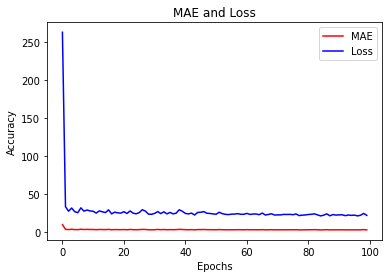

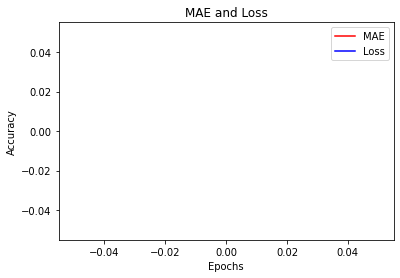

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) 

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()